Contents:

1. Importing libraries and dataset
2. Creating functions
3. Exclusion criteria
4. Brief exploratory data analysis
5. Data preparation: transform features, train-test split
6. Hyperparameter selection using cross-validation on training dataset
7. Evaluation of KNN model
8. Evaluation of category average model
9. Descriptive statistics on fibre content
10. Retrieve neighbours for products in testing dataset
11. Performance by first neighbour distance
12. Performance by training dataset size

# 1. Importing libaries and dataset

In [1]:
# Import KNN framework from sklearn
from sklearn.neighbors import KNeighborsRegressor

# Import liraries for statistical analysis
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score
from sklearn.metrics import classification_report
from scipy.stats import spearmanr
from scipy.stats import median_test
import numpy as np

# Import library for data manipulation
import pandas as pd
pd.set_option('display.max_columns', None)

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Filter all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Australian FoodSwitch dataset
df = pd.read_excel('AUS_FS.xlsx')
df.head(3)

,Product Id,Nip Type,Manufacturer Name,Brand Name,Product Name,Ingredients,Carbohydrates (g/100g),Sugars (g/100g),Total fat (g/100g),Saturated fat (g/100g),Protein (g/100g),Sodium (mg/100g),Fibre (g/100g),Major category,Minor category,Subminor category,Leaf category
0,3341,1,Aldi,Bakers Life (Aldi),Bakers Life Turkish Rolls Artisan Style,Wheat Flour [Contains Vitamins (Thiamin | Foli...,45.0,1.2,1.7,0.2,7.1,382.0,NaN,Bread and bakery products,- Bread,- Other bread,Bread rolls
1,3347,1,Aldi,Bakers Life (Aldi),Bakers Life Turkish Bread Artisan Style,Wheat Flour [Contains Vitamins (Thiamin | Foli...,41.9,2.1,1.3,0.2,7.2,382.0,3.2,Bread and bakery products,- Bread,- White bread,White bread
2,3369,1,Old Time Bakery Pty Ltd,Old Time Bakery,Old Time Bakery Gluten Free Pizza Bases,Maize Starch | Milk Solids Non-Fat | Rice Flou...,48.8,5.3,2.0,0.4,5.3,380.0,NaN,Bread and bakery products,- Bread,- Other bread,Pizza bases


# 2. Creating functions

In [3]:
# Create a function that classifies products into groups based on fibre density
def fibre_class(value):
    if value <0.9:
        return 'Negligible fibre density'
    elif value < 3.7:
        return 'Low fibre density'
    elif value < 7.3:
        return 'Medium fibre density'
    else:
        return 'High fibre density'

In [4]:
# Create a function that determines the spearman correlation between two lists, using scipy.stats spearmanr
def spearman_correlation(list1,list2):
    return spearmanr(list1, list2)[0]

# 3. Exclusion criteria

In [5]:
print('Products extracted:', df.shape[0])

# Drop multipack products
df = df[df['Nip Type']!=3]
print('Products after dropping multi-packs:', df.shape[0])

# Drop products with US NIP (just per serve) - fibre carbohydrated defined differently
df = df[df['Nip Type']!=4]
print('Products after dropping US products:', df.shape[0])

# Drop products that don't contain a NIP
c1 = (df['Carbohydrates (g/100g)'].isnull())
c2 = (df['Sugars (g/100g)'].isnull())
c3 = (df['Total fat (g/100g)'].isnull())
c4 = (df['Saturated fat (g/100g)'].isnull())
c5 = (df['Protein (g/100g)'].isnull())
c6 = (df['Sodium (mg/100g)'].isnull())
df = df[~(c1|c2|c3|c4|c5|c6)]
print('Products after dropping products without a NIP:', df.shape[0])

# Drop products that are a pack size duplicate - find by duplication of product name and NIP
df['all'] = df['Product Name'].str.lower().str.lstrip().str.rstrip() + df['Carbohydrates (g/100g)'].astype(str) + df['Sugars (g/100g)'].astype(str) + df['Total fat (g/100g)'].astype(str) + df['Saturated fat (g/100g)'].astype(str) + df['Protein (g/100g)'].astype(str)  + df['Sodium (mg/100g)'].astype(str)
df = df.drop_duplicates(subset = 'all')
print('Products after dropping pack size duplicates:', df.shape[0])

# Drop products witout a discernible brand name
df = df[~df['Brand Name'].isnull()]
print('Products after dropping products with no discernible brand name:', df.shape[0])

df.reset_index(drop=True, inplace=True)

Products extracted: 31377
Products after dropping multi-packs: 31207
Products after dropping US products: 30800
Products after dropping products without a NIP: 28252
Products after dropping pack size duplicates: 26314
Products after dropping products with no discernible brand name: 26278


# 4. Brief exploratory data analysis

In [6]:
# Construct new nutrient features
df['Starch (g/100g)'] = df['Carbohydrates (g/100g)'] - df['Sugars (g/100g)']
df['Unsaturated fat (g/100g)'] = df['Total fat (g/100g)'] - df['Saturated fat (g/100g)']

In [7]:
# Explore the distributions of the six nutrients
np.round(df[['Sugars (g/100g)', 
             'Starch (g/100g)', 
             'Saturated fat (g/100g)', 
             'Unsaturated fat (g/100g)', 
             'Protein (g/100g)', 
             'Sodium (mg/100g)',
             'Fibre (g/100g)']].describe(), 1)

,Sugars (g/100g),Starch (g/100g),Saturated fat (g/100g),Unsaturated fat (g/100g),Protein (g/100g),Sodium (mg/100g),Fibre (g/100g)
count,26278.0,26278.0,26278.0,26278.0,26278.0,26278.0,13659.0
mean,12.1,26.8,3.5,7.9,7.2,311.0,5.2
std,15.5,22.9,5.2,11.3,5.9,556.6,5.9
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.8,5.6,0.4,0.9,2.8,20.0,1.7
50%,4.6,21.7,1.3,3.4,6.2,232.0,3.6
75%,17.6,43.6,4.5,10.1,9.8,400.0,7.2
max,94.0,90.1,66.8,80.0,81.1,28000.0,90.1


In [8]:
# Explore the spearman correlations between each nutrient and fibre content
np.round(df[['Sugars (g/100g)', 
             'Starch (g/100g)', 
             'Saturated fat (g/100g)', 
             'Unsaturated fat (g/100g)', 
             'Protein (g/100g)', 
             'Sodium (mg/100g)',
             'Fibre (g/100g)']].corr(method='spearman')['Fibre (g/100g)'], 2)

Sugars (g/100g)             0.13
Starch (g/100g)             0.30
Saturated fat (g/100g)      0.29
Unsaturated fat (g/100g)    0.47
Protein (g/100g)            0.63
Sodium (mg/100g)           -0.03
Fibre (g/100g)              1.00
Name: Fibre (g/100g), dtype: float64

# 5. Data preparation: transform features, train-test split

In [9]:
# Construct a dataframe for basic product info
prod_info = df[['Product Id', 'Manufacturer Name', 'Brand Name','Product Name', 'Ingredients',
                'Major category', 'Minor category', 'Subminor category', 'Leaf category']]

# Construct a dataframe for normalised nutrient features
nutrients = ['Sugars (g/100g)', 
             'Starch (g/100g)', 
             'Saturated fat (g/100g)', 
             'Unsaturated fat (g/100g)', 
             'Protein (g/100g)', 
             'Sodium (mg/100g)']
nutrients_normalised = pd.DataFrame()
for col in nutrients:
    # Normalize nutrients between 0 and 1 by dividing by the maximum nutrient value
    nutrients_normalised[col] = df[col]/df[col].max()
    
# Construct a dataframe for dummy-coded categories
dummy_categories = pd.get_dummies(df['Minor category'], drop_first = True)

# Construct a dataframe for fibre content
target = df[['Fibre (g/100g)']]

# Combine these four dataframes
df_prep = pd.concat([prod_info, nutrients_normalised, dummy_categories, target], axis=1)

In [10]:
# Construct separate dataframes for products that do and don't report fibre content
df_fibre = df_prep[~df_prep['Fibre (g/100g)'].isnull()]
df_no_fibre = df_prep[df_prep['Fibre (g/100g)'].isnull()]

# Construct a table of brand names for products that report fibre content
brand_table = pd.DataFrame()
brand_table['Name'] = df_fibre['Brand Name'].value_counts().index.tolist()
brand_table['n'] = df_fibre['Brand Name'].value_counts().tolist()
brand_table.sort_values(by = ['n', 'Name'], ascending=[False, True], inplace=True)
brand_table['Rank'] = range(1, brand_table.shape[0]+1)
brand_table.head(10)

,Name,n,Rank
0,Coles,1309,1
1,Woolworths,826,2
2,Kellogg's,243,3
3,Arnott's,224,4
4,Macro,195,5
5,SPC Ardmona,165,6
6,Heinz,157,7
7,Woolworths Select,148,8
9,Carman's,147,9
8,SunRice,147,10


In [11]:
# Assign every fourth brand to the testing set
test_brands = brand_table[brand_table['Rank']%4==0]['Name'].tolist()
test = df_fibre[df_fibre['Brand Name'].isin(test_brands)]

# Assign all other brands to the training set
train_brands = brand_table[brand_table['Rank']%4!=0]['Name'].tolist()
train = df_fibre[df_fibre['Brand Name'].isin(train_brands)]

print(train.shape)
print(test.shape)

(10755, 31)
(2904, 31)


In [12]:
# Divide the training brands into five groups for hyperparameter tuning purposes
# Construct brand frequency table
brand_table_train = pd.DataFrame()
brand_table_train['Name'] = train['Brand Name'].value_counts().index.tolist()
brand_table_train['n'] = train['Brand Name'].value_counts().tolist()
brand_table_train.sort_values(by = ['n', 'Name'], ascending=[False, True], inplace=True)

# Assign brands to five groups: 0, 1, 2 ,3, 4
brand_table_train['Rank'] = range(0, brand_table_train.shape[0])
brand_table_train['Group'] = brand_table_train['Rank']%5

brands_1 = brand_table_train[brand_table_train['Group'] == 0]['Name'].tolist()
brands_2 = brand_table_train[brand_table_train['Group'] == 1]['Name'].tolist()
brands_3 = brand_table_train[brand_table_train['Group'] == 2]['Name'].tolist()
brands_4 = brand_table_train[brand_table_train['Group'] == 3]['Name'].tolist()
brands_5 = brand_table_train[brand_table_train['Group'] == 4]['Name'].tolist()

brand_table_train.head(10)

,Name,n,Rank,Group
0,Coles,1309,0,0
1,Woolworths,826,1,1
2,Kellogg's,243,2,2
3,Macro,195,3,3
4,SPC Ardmona,165,4,4
5,Heinz,157,5,0
6,Carman's,147,6,1
7,SunRice,147,7,2
8,Birds Eye,125,8,3
9,Uncle Tobys,111,9,4


# 6. Hyperparameter selection using cross-validation on training dataset

In [13]:
# The 5-fold cross-validation performance metrics for each hyperparameter combination will be appended here.
data = []

# Loop through numbers of neighbours.
for n in [1, 3, 5, 8, 10]:
    
    # Loop through weight functions.
    for w in ['distance', 'uniform']:
        
        # Loop through distance metrics.
        for m in ['euclidean', 'manhattan']:
            
            # Initiate the KNN algorithm using the given hyperparameters.
            KNN = KNeighborsRegressor(n_neighbors = n, weights = w, metric = m)
            
            # Create an empty dictionary. Append hyperparameter information here first
            row = {}
            row['Neighbours'] = n
            row['Weight'] = w
            row['Metric'] = m
            
            # Perform cross validation
            data2 = []
            for validation_brands in [brands_1, brands_2, brands_3, brands_4, brands_5]:
                # Construct dataframe for input features of validation brands
                X_val = train[train['Brand Name'].isin(validation_brands)]
                X_val = X_val[X_val.columns[9:-1]]

                # Construct dataframe for fibre values of validation brands
                y_val = train[train['Brand Name'].isin(validation_brands)]
                y_val = y_val[y_val.columns[-1]]

                # Construct dataframe for input features of training brands
                X_train = train[~train['Brand Name'].isin(validation_brands)]
                X_train = X_train[X_train.columns[9:-1]]

                # Construct dataframe for fibre values of training brands
                y_train = train[~train['Brand Name'].isin(validation_brands)]
                y_train = y_train[y_train.columns[-1]]
                
                # Train model
                model = KNN.fit(X_train, y_train)
                
                # Apply model
                y_pred = model.predict(X_val)
                
                # Obtain performance metrics for each iteration
                row2 = {}
                row2['R2'] = r2_score(y_val, y_pred)
                row2['MAE'] = mean_absolute_error(y_val, y_pred)
                row2['SRC'] = spearman_correlation(y_val, y_pred)
                row2['CA'] = accuracy_score(y_val.apply(fibre_class).reset_index(drop=True), pd.Series(y_pred).apply(fibre_class))
                data2.append(row2)
            
            # Obtain the average across all iterations
            metrics = pd.DataFrame(data2)
            row['R2'] = np.round(metrics['R2'].mean(), 2)
            row['MAE'] = np.round(metrics['MAE'].mean(), 2)
            row['SRC'] = np.round(metrics['SRC'].mean(), 2)
            row['CA'] = np.round(metrics['CA'].mean(), 2)
            data.append(row)
            
HPT = pd.DataFrame(data)
HPT

,Neighbours,Weight,Metric,R2,MAE,SRC,CA
0,1,distance,euclidean,0.67,1.75,0.79,0.66
1,1,distance,manhattan,0.67,1.72,0.80,0.66
2,1,uniform,euclidean,0.67,1.75,0.79,0.66
3,1,uniform,manhattan,0.67,1.72,0.80,0.66
4,3,distance,euclidean,0.73,1.56,0.83,0.69
5,3,distance,manhattan,0.73,1.57,0.83,0.69
6,3,uniform,euclidean,0.73,1.63,0.83,0.68
7,3,uniform,manhattan,0.72,1.64,0.83,0.69
8,5,distance,euclidean,0.74,1.54,0.84,0.69
9,5,distance,manhattan,0.74,1.53,0.84,0.69


In [14]:
# Train the model on all training data using the ideal hyperparameters
KNN = KNeighborsRegressor(n_neighbors = 8, weights = 'distance', metric = 'manhattan')
X = train[train.columns[9:-1]]
y = train[train.columns[-1]]
model = KNN.fit(X, y)

# 7. Evaluation of KNN model

In [15]:
# Apply the model to the test set
test['Predicted fibre (g/100g)'] = np.round(model.predict(test[test.columns[9:-1]]), 1)

# Construct fields for fibre density classes
test['Fibre (g/100g) class'] = test['Fibre (g/100g)'].apply(fibre_class)
test['Predicted fibre (g/100g) class'] = test['Predicted fibre (g/100g)'].apply(fibre_class)

In [16]:
data3 = []

# Explore the performance across all test products
row = {}
row['Minor category'] = 'All categories'
row['n']= test.shape[0]    

row['Fibre (g/100g) median'] = np.round(test['Fibre (g/100g)'].median(), 2)
fibre_q1 = np.round(np.percentile(test['Fibre (g/100g)'], 25), 2)
fibre_q3 = np.round(np.percentile(test['Fibre (g/100g)'], 75), 2)
row['Fibre (g/100g) IQR'] = fibre_q3 - fibre_q1

row['Predicted fibre (g/100g) median'] = np.round(test['Predicted fibre (g/100g)'].median(), 2)
pred_fibre_q1 = np.round(np.percentile(test['Predicted fibre (g/100g)'], 25), 2)
pred_fibre_q3 = np.round(np.percentile(test['Predicted fibre (g/100g)'], 75), 2)
row['Predicted fibre (g/100g) IQR'] = pred_fibre_q3 - pred_fibre_q1

row['R2'] = np.round(r2_score(test['Fibre (g/100g)'], test['Predicted fibre (g/100g)']), 2)
row['MAE'] = np.round(mean_absolute_error(test['Fibre (g/100g)'], test['Predicted fibre (g/100g)']), 2)
row['SRC'] = np.round(spearman_correlation(test['Fibre (g/100g)'], test['Predicted fibre (g/100g)']), 2)
row['CA'] = np.round(accuracy_score(test['Fibre (g/100g) class'], test['Predicted fibre (g/100g) class']), 2)
data3.append(row)

# Explore the performance across Minor food categories
Minor_cats = test['Minor category'].value_counts().index.tolist()
for Minor_cat in Minor_cats:
    subset = test[test['Minor category'] == Minor_cat]
    row = {}
    row['Minor category'] = Minor_cat
    row['n']= subset.shape[0]    
    
    row['Fibre (g/100g) median'] = np.round(subset['Fibre (g/100g)'].median(), 2)
    fibre_q1 = np.round(np.percentile(subset['Fibre (g/100g)'], 25), 2)
    fibre_q3 = np.round(np.percentile(subset['Fibre (g/100g)'], 75), 2)
    row['Fibre (g/100g) IQR'] = fibre_q3 - fibre_q1

    row['Predicted fibre (g/100g) median'] = np.round(subset['Predicted fibre (g/100g)'].median(), 2)
    pred_fibre_q1 = np.round(np.percentile(subset['Predicted fibre (g/100g)'], 25), 2)
    pred_fibre_q3 = np.round(np.percentile(subset['Predicted fibre (g/100g)'], 75), 2)
    row['Predicted fibre (g/100g) IQR'] = pred_fibre_q3 - pred_fibre_q1
   
    row['R2'] = np.round(r2_score(subset['Fibre (g/100g)'], subset['Predicted fibre (g/100g)']), 2)
    row['MAE'] = np.round(mean_absolute_error(subset['Fibre (g/100g)'], subset['Predicted fibre (g/100g)']), 2)
    row['SRC'] = np.round(spearman_correlation(subset['Fibre (g/100g)'], subset['Predicted fibre (g/100g)']), 2)     
    row['CA'] = np.round(accuracy_score(subset['Fibre (g/100g) class'], subset['Predicted fibre (g/100g) class']), 2)
    data3.append(row)

KNN_performance = pd.DataFrame(data3)
KNN_performance.sort_values(by = 'Minor category')

,Minor category,n,Fibre (g/100g) median,Fibre (g/100g) IQR,Predicted fibre (g/100g) median,Predicted fibre (g/100g) IQR,R2,MAE,SRC,CA
1,- Biscuits,378,3.80,2.38,3.80,2.48,0.26,1.65,0.57,0.64
4,- Bread,272,4.40,3.20,4.10,1.90,0.26,1.61,0.49,0.58
6,- Breakfast cereals,231,9.50,3.10,9.30,2.90,0.70,1.79,0.68,0.84
12,"- Cakes, muffins and pastries",95,2.20,3.30,2.20,0.90,-0.14,3.16,0.18,0.52
9,- Cereal and nut -based bars,191,7.40,3.60,7.50,2.05,0.55,2.10,0.55,0.70
7,- Crisps and snacks,220,4.45,4.90,4.65,4.12,0.36,2.12,0.71,0.60
2,- Fruit,279,5.50,5.55,6.40,4.85,0.48,2.03,0.72,0.65
3,- Fruit and vegetable juices,273,1.00,0.80,0.60,0.50,0.12,0.35,0.48,0.66
15,- Noodles,25,1.90,1.90,1.50,2.00,0.03,0.80,0.64,0.64
13,- Nuts and seeds,93,7.70,3.80,7.70,2.90,-0.03,1.94,0.55,0.68


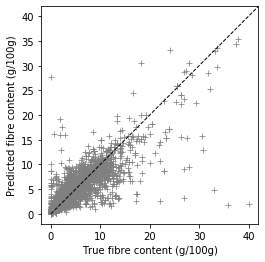

In [17]:
# Scatter plot
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.axis('scaled')
g = sns.scatterplot(color = 'grey',x = 'Fibre (g/100g)', y = 'Predicted fibre (g/100g)', data = test, marker = '+')
plt.plot([0, 100], [0, 100], 'black', linewidth = 1, linestyle = "--");
plt.xlabel('True fibre content (g/100g)')
plt.ylabel('Predicted fibre content (g/100g)');
g.get_figure().savefig('Fibre plot.png', dpi = 400)

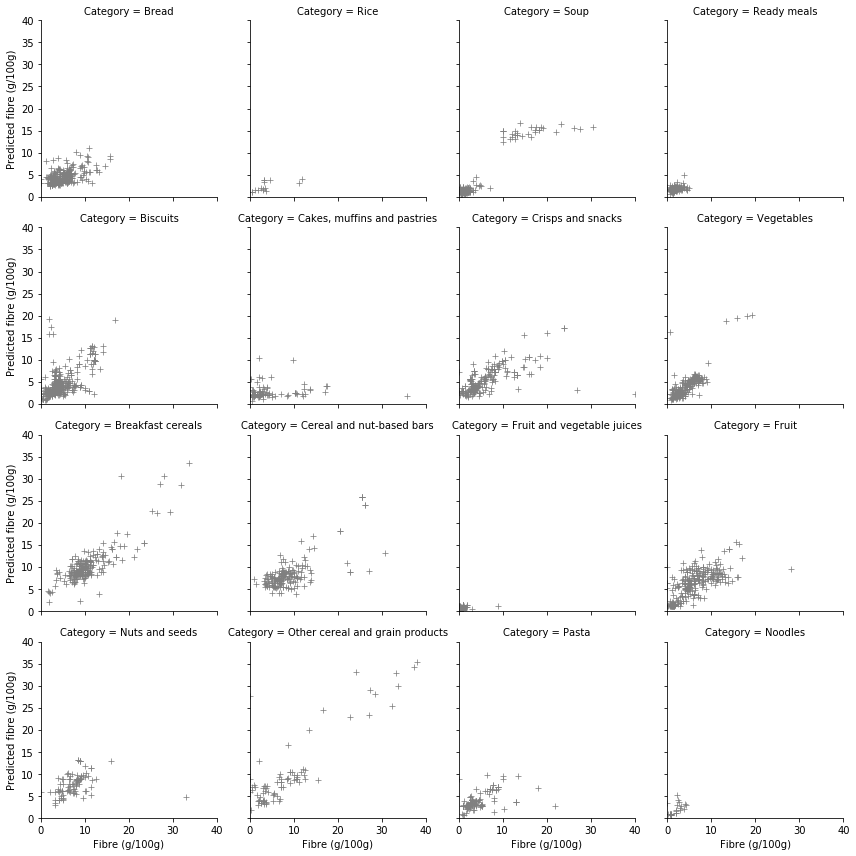

In [18]:
# Scatter plots for each category
test['Category'] = test['Minor category'].str.split(' - ').str[1].str.replace(' -', '-')
f = sns.FacetGrid(test, col = 'Category', col_wrap = 4, ylim = (0, 40), xlim = (0, 40))
f.map(sns.scatterplot, "Fibre (g/100g)", "Predicted fibre (g/100g)", marker = '+', color = 'grey')
f.savefig('Fibre cat plot.png', dpi = 500)

In [19]:
# Test difference in medians
median_test(test['Fibre (g/100g)'], test['Predicted fibre (g/100g)'])

(1.3971755224618192, 0.2371970532107331, 4.0, array([[1367, 1413],
        [1537, 1491]], dtype=int64))

In [20]:
# Confusion matrix
data4 = []
for group in ['Negligible fibre density', 'Low fibre density', 'Medium fibre density','High fibre density']:
    row = test[test['Fibre (g/100g) class'] == group]['Predicted fibre (g/100g) class'].value_counts().to_dict()
    data4.append(row)
    
KNN_matrix = pd.DataFrame(data4)
KNN_matrix.index = ['Negligible fibre density', 'Low fibre density', 'Medium fibre density','High fibre density']
KNN_matrix
# Rows are the true class, columns are the predicted class

,Negligible fibre density,Low fibre density,Medium fibre density,High fibre density
Negligible fibre density,132.0,112,13,5
Low fibre density,86.0,797,222,27
Medium fibre density,NaN,162,498,114
High fibre density,NaN,43,159,534


In [21]:
print(classification_report(test['Fibre (g/100g) class'], test['Predicted fibre (g/100g) class']))

                          precision    recall  f1-score   support

      High fibre density       0.79      0.73      0.75       736
       Low fibre density       0.72      0.70      0.71      1132
    Medium fibre density       0.56      0.64      0.60       774
Negligible fibre density       0.61      0.50      0.55       262

                accuracy                           0.68      2904
               macro avg       0.67      0.64      0.65      2904
            weighted avg       0.68      0.68      0.68      2904



# 8. Evaluation of category average model

In [22]:
# Construct a dataframe of all mean fibre values for each leaf category
leaf_means = pd.DataFrame()
leaf_means['Leaf category'] = train.groupby('Leaf category')['Fibre (g/100g)'].mean().index.tolist()
leaf_means['Leaf category mean fibre (g/100g)'] = np.round(train.groupby('Leaf category')['Fibre (g/100g)'].mean().tolist(), 1)

# Do the same for subminor categories
subminor_means = pd.DataFrame()
subminor_means['Subminor category'] = train.groupby('Subminor category')['Fibre (g/100g)'].mean().index.tolist()
subminor_means['Subminor category mean fibre (g/100g)'] = np.round(train.groupby('Subminor category')['Fibre (g/100g)'].median().tolist(), 1)

# Merge category means onto test dataset
test = test.merge(leaf_means, on = 'Leaf category', how = 'left')
test = test.merge(subminor_means, on = 'Subminor category', how = 'left')
#test = test.merge(minor_means, on = 'Minor category', how = 'left')

# Assume each testing product's fibre value is equal to the mean leaf category value in the 
# training dataset. Use subminor category average where leaf category average isn't available
c1 = test['Leaf category mean fibre (g/100g)'].isnull()
test['Category average fibre (g/100g)'] = np.where(c1, test['Subminor category mean fibre (g/100g)'], test['Leaf category mean fibre (g/100g)'])

# Determine fibre class based on category average prediction
test['Category average fibre (g/100g) class'] = test['Category average fibre (g/100g)'].apply(fibre_class)

In [23]:
# Print performance metrics for the category imputation method
print('R2:', np.round(r2_score(test['Fibre (g/100g)'], test['Category average fibre (g/100g)']), 2))
print('MAE:', np.round(mean_absolute_error(test['Fibre (g/100g)'], test['Category average fibre (g/100g)']), 2))
print('SRC:', np.round(spearman_correlation(test['Fibre (g/100g)'], test['Category average fibre (g/100g)']), 2))
print('CA:', np.round(accuracy_score(test['Fibre (g/100g) class'], test['Category average fibre (g/100g) class']), 2))


R2: 0.43
MAE: 2.13
SRC: 0.79
CA: 0.61


# 9. Descriptive statistics on fibre content

In [24]:
# First, retrain the model using ALL products that report fibre content. Not just the training dataset
X2 = df_fibre[df_fibre.columns[9:-1]]
y2 = df_fibre[df_fibre.columns[-1]].reset_index(drop=True)
model2 = KNN.fit(X2, y2)

# Apply the model to the products that don't report fibre content
df_no_fibre['Predicted fibre (g/100g)'] = np.round(model2.predict(df_no_fibre[df_no_fibre.columns[9:-1]]), 1)

In [25]:
# Explore the fibre distributions across all products (both report and don't report fibre content)
df_all = pd.concat([df_fibre, df_no_fibre])[['Major category', 'Minor category', 'Fibre (g/100g)','Predicted fibre (g/100g)']]
df_all['Fibre value'] = np.where(df_all['Fibre (g/100g)'].isnull(), 'Predicted', 'Reported')
df_all['All fibre (g/100g)'] = np.where(df_all['Fibre (g/100g)'].isnull(), df_all['Predicted fibre (g/100g)'], df_all['Fibre (g/100g)'])

data7 = []

row = np.round(df_all['All fibre (g/100g)'].describe(), 1).to_dict()
row['Minor category'] = 'All'
row['%'] = np.round(100*(df_all.shape[0] - df_all['Fibre (g/100g)'].isnull().sum())/df_all.shape[0], 1)
data7.append(row)

# Minor categories
for Minor_cat in Minor_cats:
    subset = df_all[df_all['Minor category'] == Minor_cat]
    row = np.round(subset['All fibre (g/100g)'].describe(), 1).to_dict()
    row['Minor category'] = Minor_cat
    row['%'] = np.round(100*(subset.shape[0] - subset['Fibre (g/100g)'].isnull().sum())/subset.shape[0], 1)
    data7.append(row)

fibre_description = pd.DataFrame(data7)[['Minor category',
                     'count', '%', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

fibre_description.sort_values(by = 'Minor category')

,Minor category,count,%,mean,std,min,25%,50%,75%,max
1,- Biscuits,2917.0,38.1,3.8,2.8,0.0,2.3,3.1,4.3,23.0
4,- Bread,2286.0,62.8,4.6,2.3,0.0,3.0,4.0,5.7,29.1
6,- Breakfast cereals,1662.0,87.9,9.0,4.7,0.0,6.8,8.7,10.8,42.8
12,"- Cakes, muffins and pastries",2273.0,28.9,2.5,2.0,0.0,1.7,2.1,2.8,35.8
9,- Cereal and nut -based bars,903.0,88.9,7.8,4.5,0.0,5.5,7.1,9.0,30.8
7,- Crisps and snacks,2080.0,52.2,5.1,3.7,0.0,2.8,3.8,6.4,40.1
2,- Fruit,2032.0,61.4,5.3,4.0,0.0,1.5,5.0,7.8,33.1
3,- Fruit and vegetable juices,1864.0,50.0,0.6,0.5,0.0,0.3,0.6,1.0,9.0
15,- Noodles,583.0,30.2,1.8,1.5,0.0,0.9,1.6,2.3,19.7
13,- Nuts and seeds,1344.0,46.9,7.6,3.4,0.0,5.7,7.4,9.0,37.5


# 10. Retrieve neighbours for predictions in test dataset

In [26]:
X = train[train.columns[9:-1]]
y = train[train.columns[-1]]
model = KNN.fit(X, y)
train.reset_index(drop=True, inplace=True)

In [27]:
# Create an empty dataframe. Vertically concatenate product + neighbours to this dataframe
big = pd.DataFrame()

# Loop through each product in the testing dataset
for i in range(0, test.shape[0]):
    # Access the eight nearest neighbours for each testing product
    neighbours =  model.kneighbors([test[test.columns[9:-9]].iloc[i].as_matrix()])
    
    # Access the indexes of these neighbours:
    indexes = neighbours[1][0]
    
    # Access the distances between these neighbours and the query product
    distances = neighbours[0][0]
    
    # Acess product data for the query product
    desired_cols = ['Product Id', 'Manufacturer Name', 'Brand Name', 'Product Name','Ingredients', 
                       'Major category', 'Minor category', 'Subminor category','Leaf category', 
                       'Sugars (g/100g)', 'Starch (g/100g)','Saturated fat (g/100g)', 'Unsaturated fat (g/100g)',
                       'Protein (g/100g)', 'Sodium (mg/100g)', 
                       'Fibre (g/100g)']
    
    query_data = test[test.index == i][desired_cols + ['Predicted fibre (g/100g)','Category average fibre (g/100g)']]
   
    # Acess product data for the neighbours
    n1 = train[train.index == indexes[0]]
    n2 = train[train.index == indexes[1]]
    n3 = train[train.index == indexes[2]]
    n4 = train[train.index == indexes[3]]
    n5 = train[train.index == indexes[4]]
    n6 = train[train.index == indexes[5]]
    n7 = train[train.index == indexes[6]]
    n8 = train[train.index == indexes[7]]   
    neighbours_data = pd.concat([n1, n2, n3, n4, n5, n6, n7, n8])[desired_cols]
    neighbours_data['d'] = distances
    
    # Vertically concatenate product and neighbours data
    combine_data = pd.concat([query_data, neighbours_data])[query_data.columns.tolist() + ['d']]
    
    # Vertically concatenate this dataframe onto the big dataframe
    big = pd.concat([big, combine_data])

# Convert nutrients back to their original values
for col in nutrients:
    big[col] = np.round(big[col]*df[col].max(), 1)
    
big['MAE'] = np.abs(big['Fibre (g/100g)'] - big['Predicted fibre (g/100g)']).ffill()
big['Original order'] = range(0, big.shape[0])
big.sort_values(by = ['MAE', 'Original order'], ascending = [False, True], inplace=True)
big.reset_index(drop=True, inplace=True)

In [28]:
big.shape[0]

26136

In [29]:
# Example
big.iloc[19989:19998]

,Product Id,Manufacturer Name,Brand Name,Product Name,Ingredients,Major category,Minor category,Subminor category,Leaf category,Sugars (g/100g),Starch (g/100g),Saturated fat (g/100g),Unsaturated fat (g/100g),Protein (g/100g),Sodium (mg/100g),Fibre (g/100g),Predicted fibre (g/100g),Category average fibre (g/100g),d,MAE,Original order
19989,51658,Aldi,Corale (Aldi),Corale Baked Beans in Tomato Sauce,Navy Beans (49%) | Water | Sugar | Tomato Pure...,Fruit and vegetables,- Vegetables,- Canned vegetables,Baked beans,7.5,7.3,0.1,0.4,4.7,457.0,4.4,4.7,4.8,NaN,0.3,2817
19990,52404,Heinz Australia,Wattie's,Wattie's Baked Beans,"tomato sauce (53%) [tomatoes, sugar, salt, whe...",Fruit and vegetables,- Vegetables,- Canned vegetables,Baked beans,7.6,8.2,0.1,0.4,4.8,470.0,5.3,NaN,NaN,0.012750,0.3,2818
19991,52475,Heinz Australia,Wattie's,Wattie's Baked Beans in Tomato Sauce,Navy Beans (51%) (Contains Traces of Soy) | To...,Fruit and vegetables,- Vegetables,- Canned vegetables,Baked beans,7.3,7.8,0.1,0.4,5.1,450.0,4.6,NaN,NaN,0.012859,0.3,2819
19992,52392,HJ Heinz Company Australia Ltd,Heinz,Heinz Beanz Ham Sauce,Ham Sauce (50%) [Water | Tomatoes (10%) | Suga...,Fruit and vegetables,- Vegetables,- Canned vegetables,Baked beans,6.3,6.9,0.1,0.3,4.3,435.0,3.6,NaN,NaN,0.024173,0.3,2820
19993,200393,Heinz Australia,Wattie's,Wattie's Full of Beanz,Navy Beans (51%) | Tomato Sauce (49%) [Tomatoe...,Fruit and vegetables,- Vegetables,- Canned vegetables,Baked beans,7.4,8.7,0.1,0.5,5.2,450.0,5.7,NaN,NaN,0.024267,0.3,2821
19994,1172481,HJ Heinz Company Australia Ltd,Heinz,Heinz Beanz BBQ Sauce,Navy Beans (51%) | BBQ Sauce (49%) [Tomatoes (...,Fruit and vegetables,- Vegetables,- Canned vegetables,Baked beans,6.9,8.6,0.1,0.8,4.9,485.0,4.2,NaN,NaN,0.029277,0.3,2822
19995,52503,SPC Ardmona Operations Limited,SPC Ardmona,SPC Ardmona Baked Beans BBQ Flavour,Navy Beans (50%) | BBQ Flavoured Sauce [Tomato...,Fruit and vegetables,- Vegetables,- Canned vegetables,Baked beans,6.0,8.1,0.1,0.4,4.8,358.0,4.1,NaN,NaN,0.029605,0.3,2823
19996,52408,HJ Heinz Company Australia Ltd,Heinz,Heinz Beanz BBQ Sauce,Barbecue Sauce (54%) [Tomatoes (29%) | Water |...,Fruit and vegetables,- Vegetables,- Canned vegetables,Baked beans,6.8,8.7,0.1,0.8,4.6,490.0,4.9,NaN,NaN,0.030397,0.3,2824
19997,52520,SPC Ardmona Operations Limited,SPC Ardmona,SPC Ardmona Baked Beans Rich Tomato,Navy Beans (50%) | Rich Tomato Sauce [Tomato P...,Fruit and vegetables,- Vegetables,- Canned vegetables,Baked beans,5.8,8.0,0.1,0.4,4.8,357.0,4.1,NaN,NaN,0.030659,0.3,2825


# 11. Performance by first neighour distance

In [30]:
big['Predicted fibre (g/100g)'] = big['Predicted fibre (g/100g)'].ffill()
big['Query fibre (g/100g)'] = np.where(big['d'].isnull(), big['Fibre (g/100g)'], np.NaN)
big['Query fibre (g/100g)'] = big['Query fibre (g/100g)'].ffill()

first_neighbours = big[big.index % 9 == 1]

In [31]:
# determine first neighbours distance quartiles
q1 = np.percentile(first_neighbours['d'], 25)
q2 = np.percentile(first_neighbours['d'], 50)
q3 = np.percentile(first_neighbours['d'], 75)

# Divide test products into four groups based on quartiles
group_1 = first_neighbours[(first_neighbours['d'] < q1)]
group_2 = first_neighbours[(first_neighbours['d'] >= q1) & (first_neighbours['d'] < q2)]
group_3 = first_neighbours[(first_neighbours['d'] >= q2) & (first_neighbours['d'] < q3)]
group_4 = first_neighbours[(first_neighbours['d'] >= q3)]

# Determine performance metrics for each group

In [32]:
data10 = []

for group in [group_1, group_2, group_3, group_4]:
    row = {}
    row['n'] = group.shape[0]
    row['R2'] = np.round(r2_score(group['Query fibre (g/100g)'], group['Predicted fibre (g/100g)']), 2)
    row['MAE'] = np.round(mean_absolute_error(group['Query fibre (g/100g)'], group['Predicted fibre (g/100g)']), 2)
    row['SRC'] = np.round(spearman_correlation(group['Query fibre (g/100g)'], group['Predicted fibre (g/100g)']), 2)     
    row['CA'] = np.round(accuracy_score(group['Query fibre (g/100g)'].apply(fibre_class), group['Predicted fibre (g/100g)'].apply(fibre_class)), 2)
    data10.append(row) 

by_distance = pd.DataFrame(data10)
by_distance

,n,R2,MAE,SRC,CA
0,726,0.98,0.47,0.90,0.78
1,726,0.75,1.18,0.82,0.67
2,726,0.66,1.81,0.78,0.65
3,726,0.42,2.80,0.62,0.60


In [33]:
print(q1)
print(q2)
print(q3)

0.017099284061107
0.037921508495744265
0.07264944468096594


# 12. Performance by training dataset size

In [34]:
data11 = []
for size in [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]:
    train_subset = train.head(size)
    X3 = train_subset[train_subset.columns[9:-1]].reset_index(drop=True)    
    y3 = train_subset[train_subset.columns[-1]].reset_index(drop=True)
    
    model3 = KNN.fit(X3, y3)
    pred = model3.predict(test[test.columns[9:-9]])
    true = test[test.columns[-9]]
    
    row = {}
    row['n']= size         
    row['R2'] = np.round(r2_score(true, pred), 2)
    row['MAE'] = np.round(mean_absolute_error(true, pred), 2)
    row['SRC'] = np.round(spearman_correlation(true, pred), 2)
    row['CA'] = np.round(accuracy_score(true.apply(fibre_class), pd.Series(pred).apply(fibre_class)), 2)
    data11.append(row)
    
learning = pd.DataFrame(data11)
learning

,n,R2,MAE,SRC,CA
0,2000,0.56,2.00,0.78,0.60
1,3000,0.61,1.91,0.80,0.62
2,4000,0.65,1.79,0.81,0.64
3,5000,0.67,1.74,0.82,0.63
4,6000,0.69,1.67,0.82,0.64
5,7000,0.70,1.66,0.82,0.65
6,8000,0.70,1.62,0.83,0.66
7,9000,0.72,1.59,0.83,0.66
8,10000,0.72,1.58,0.84,0.67
